## Can neural nets adapt to imbalance?

### Experiments with ReLU thresholding

ReLU uses 0 ($p=0.5$) as an activation threshold in the log odds space for classification. 

However, for imbalanced data, the threshold may be suboptimal. This experiment tries to track the impact of thresholding on the learning process of neural networks.

Author: https://www.github.com/deburky

## Datasets

In this step create different imbalanced datasets to test the performance of the ReLU thresholds.

In [1]:
# -*- coding: utf-8 -*-
from sklearn.datasets import make_classification

# Generate synthetic balanced binary classification data
def generate_imbalanced_data(num_samples=1000, num_features=10, imbalance_ratio=0.1):
    """
    Generate imbalanced binary classification data.

    Parameters:
    - num_samples: Total number of samples
    - num_features: Number of features

    Returns:
    - X: Feature matrix
    - y: Labels
    """
    X, y = make_classification(
        n_samples=num_samples,
        n_features=num_features,
        n_informative=num_features,
        n_redundant=0,
        n_clusters_per_class=1,
        weights=[1 - imbalance_ratio, imbalance_ratio],
    )
    return X, y

## Experiment

We use bootstrapping to estimate the confidence intervals of the results.

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, TensorDataset, random_split
from scipy.special import logit, expit
from sklearn.metrics import log_loss, roc_auc_score, balanced_accuracy_score
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Custom ReLU activation function
class CustomReLU(nn.Module):
    def __init__(self, threshold=0):
        super().__init__()
        self.threshold = threshold

    def forward(self, x):
        return torch.max(torch.tensor(self.threshold, dtype=x.dtype, device=x.device), x)

# Neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_dim, threshold):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 100)
        self.relu = CustomReLU(threshold=threshold)
        self.fc2 = nn.Linear(100, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Parameters
NUM_EPOCHS = 30
NUM_SAMPLES = 1_000
N_BOOTSTRAP = 10
BATCH_SIZE = 32
LEARNING_RATE = 1e-5

# Helper function to train and evaluate the model
def train_and_evaluate(model, dataloader_train, dataloader_test, criterion, optimizer, binary_threshold=0.5):
    # Train the model
    for _ in range(NUM_EPOCHS):
        model.train()
        for inputs, targets in dataloader_train:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Evaluate the model
    model.eval()
    all_outputs, all_targets = [], []
    with torch.no_grad():
        for inputs, targets in dataloader_test:
            outputs = model(inputs)
            predictions = torch.sigmoid(outputs)
            all_outputs.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Convert to numpy arrays
    all_outputs = np.vstack(all_outputs)
    all_targets = np.vstack(all_targets)

    # Compute metrics
    auc_score = roc_auc_score(all_targets, all_outputs)
    gini_score = auc_score * 2 - 1
    log_likelihood = log_loss(all_targets, all_outputs)
    balanced_acc = balanced_accuracy_score(all_targets, all_outputs > binary_threshold)

    return {"Gini Score": gini_score, "Log Loss": log_likelihood, "Balanced Accuracy": balanced_acc}

# Main loop for imbalance ratios and bootstrap iterations
results = []
chosen_confidence = 0.5
lower_bound = (1 - chosen_confidence) / 2
upper_bound = (1 + chosen_confidence) / 2

for ratio in np.linspace(0.01, 0.3, 30):
    # Generate imbalanced data
    X, y = generate_imbalanced_data(num_samples=NUM_SAMPLES, imbalance_ratio=ratio, num_features=10)
    logit_threshold = logit(ratio)

    # Convert to PyTorch tensors
    dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(1))
    dataset_indices = np.arange(len(dataset))

    # Train and evaluate models
    for model_type, threshold in [("ReLU threshold=0", 0), ("ReLU threshold=logit(y)", logit_threshold)]:
        bootstrap_metrics = []
        for _ in range(N_BOOTSTRAP):
            # Create bootstrap sample and split
            bootstrap_indices = np.random.choice(dataset_indices, size=len(dataset_indices), replace=True)
            bootstrap_subset = Subset(dataset, bootstrap_indices)
            train_size = int(0.7 * len(bootstrap_subset))
            train_dataset, test_dataset = random_split(bootstrap_subset, [train_size, len(bootstrap_subset) - train_size])

            # Create DataLoaders
            dataloader_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
            dataloader_test = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

            # Train and evaluate
            model = SimpleNN(input_dim=10, threshold=threshold)
            criterion = nn.BCEWithLogitsLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
            metrics = train_and_evaluate(model, dataloader_train, dataloader_test, criterion, optimizer, binary_threshold=expit(logit_threshold))
            bootstrap_metrics.append(metrics)

        # Aggregate metrics
        bootstrap_df = pd.DataFrame(bootstrap_metrics)
        aggregated_metrics = {
            "Imbalance Ratio": ratio,
            "Model Type": model_type,
            "Gini Score": bootstrap_df["Gini Score"].mean(),
            "Gini Score CI Lower": bootstrap_df["Gini Score"].quantile(lower_bound),
            "Gini Score CI Upper": bootstrap_df["Gini Score"].quantile(upper_bound),
            "Balanced Accuracy": bootstrap_df["Balanced Accuracy"].mean(),
            "Balanced Accuracy CI Lower": bootstrap_df["Balanced Accuracy"].quantile(lower_bound),
            "Balanced Accuracy CI Upper": bootstrap_df["Balanced Accuracy"].quantile(upper_bound),
            "Log Loss": bootstrap_df["Log Loss"].mean(),
            "Log Loss CI Lower": bootstrap_df["Log Loss"].quantile(lower_bound),
            "Log Loss CI Upper": bootstrap_df["Log Loss"].quantile(upper_bound),
        }
        results.append(aggregated_metrics)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

## Metric visualization

In this step we plot the metrics across different imbalance ratios and model types.

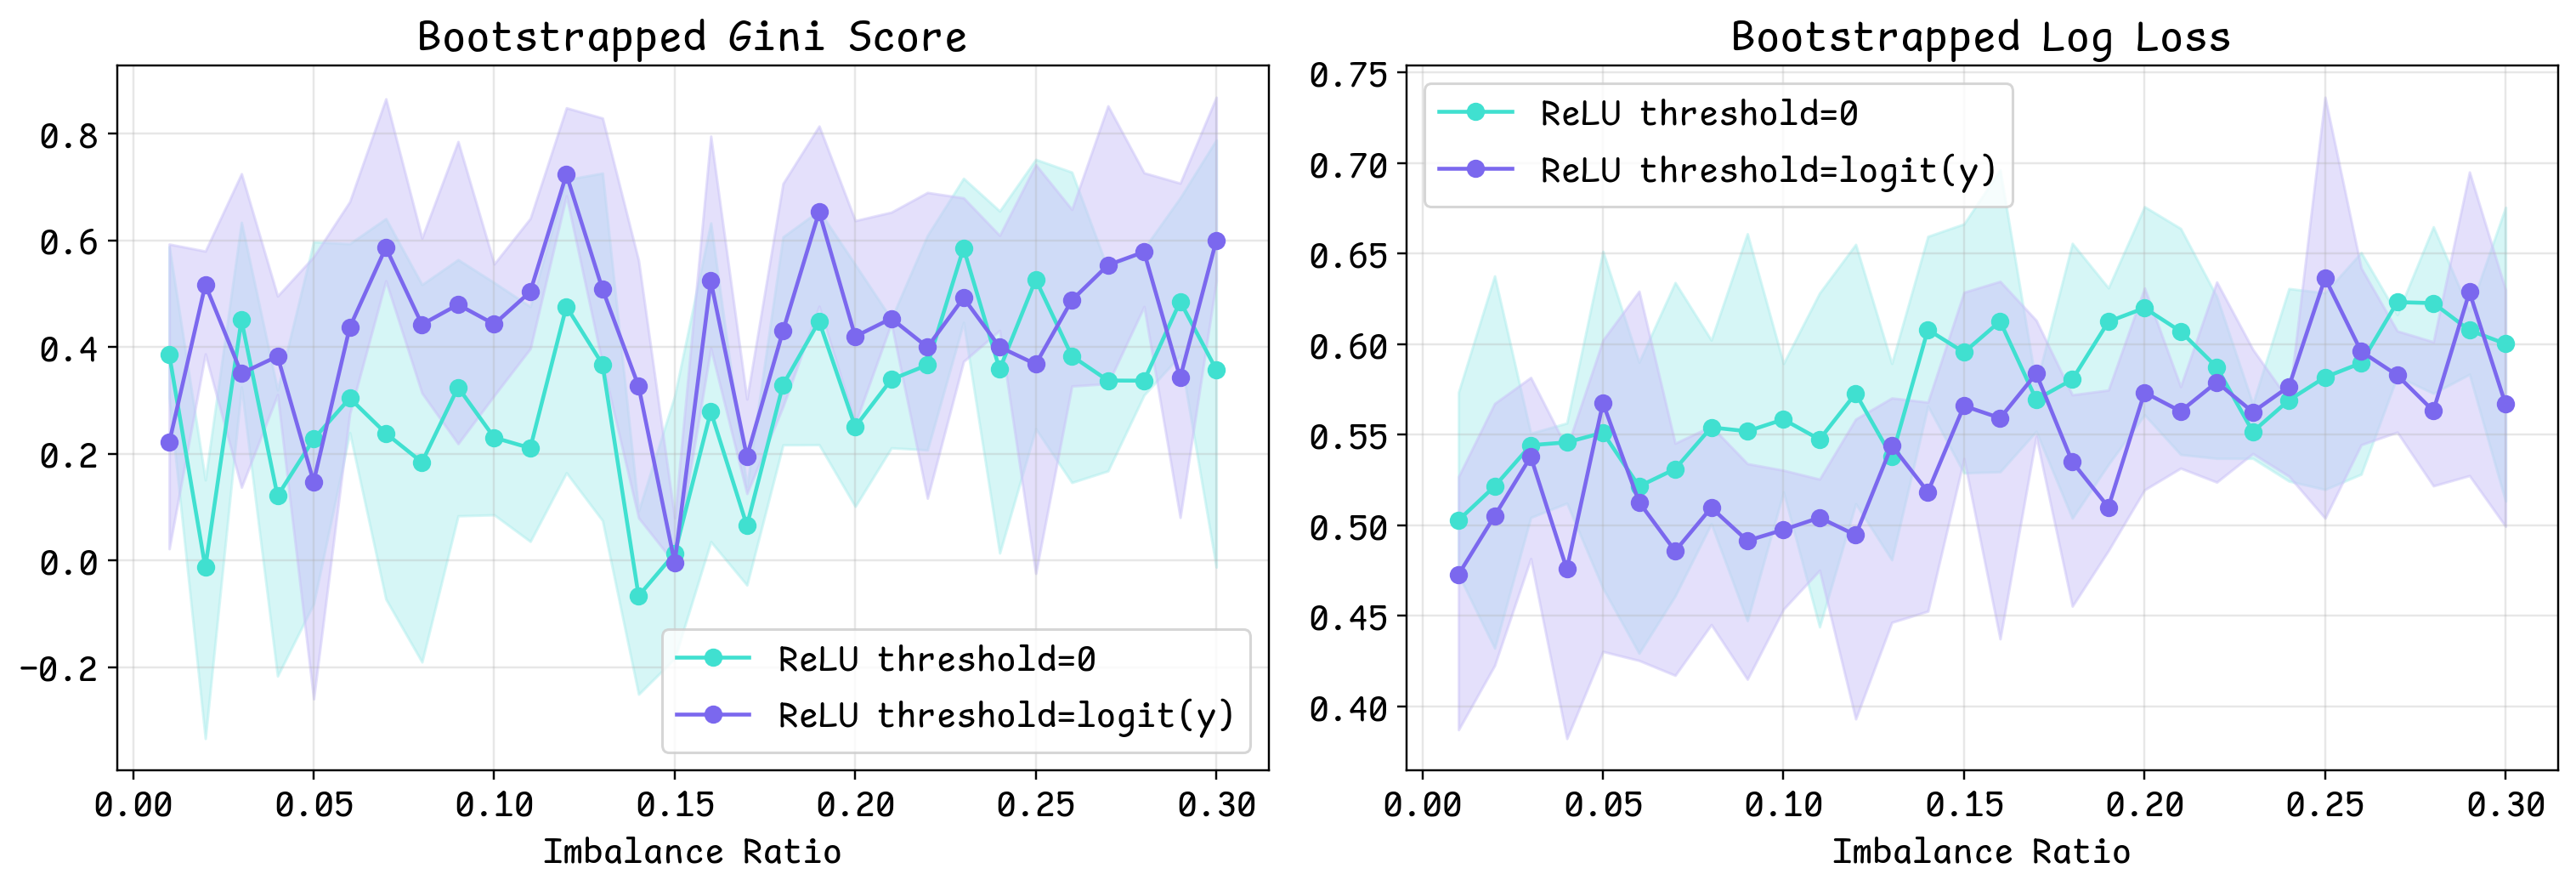

In [4]:
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
%config InlineBackend.figure_format = 'retina'

# Path to font file
font_path = "/Users/deburky/Library/Fonts/comic shanns 2.ttf"
fm.fontManager.addfont(font_path)
plt.rcParams["font.family"] = fm.FontProperties(fname=font_path).get_name()
plt.rcParams.update({"font.size": 14})

def plot_results(results_df, metric1, metric2):
    """
    Plots two selected metrics from the results_df.

    Parameters:
    - results_df: DataFrame containing results with metrics and confidence intervals.
    - metric1: First metric to plot (e.g., "Gini Score").
    - metric2: Second metric to plot (e.g., "Log-Likelihood").
    """
    fig, ax = plt.subplots(1, 2, figsize=(14, 5), dpi=110)

    _plot_metrics(results_df, ax, 0, metric1)
    _plot_metrics(results_df, ax, 1, metric2)
    plt.tight_layout()
    plt.show()

def _plot_metrics(results_df, ax, arg2, arg3):
    # Plot the first metric
    for model_type in results_df["Model Type"].unique():
        model_data = results_df[results_df["Model Type"] == model_type]
        color = 'turquoise' if model_type == "ReLU threshold=0" else "#7B68EE"
        color_fill = '#AFEEEE' if model_type == "ReLU threshold=0" else "#CAC2F8"
        ax[arg2].plot(
            model_data["Imbalance Ratio"],
            model_data[arg3],
            label=model_type,
            marker='o',
            color=color,
        )
        ax[arg2].fill_between(
            model_data["Imbalance Ratio"],
            model_data[f"{arg3} CI Lower"],
            model_data[f"{arg3} CI Upper"],
            color=color_fill,
            alpha=0.5,
        )
    ax[arg2].set_title(f"Bootstrapped {arg3}")
    ax[arg2].set_xlabel("Imbalance Ratio")
    ax[arg2].legend()
    ax[arg2].grid(alpha=0.3)

# Plot Gini Score and Log Loss
plot_results(results_df, "Gini Score", "Log Loss")

## The effect of the ReLU threshold on log loss

Here we examine for a fixed prevalence (e.g., 0.05) the impact of the ReLU threshold on the learning process.

### Variant 1

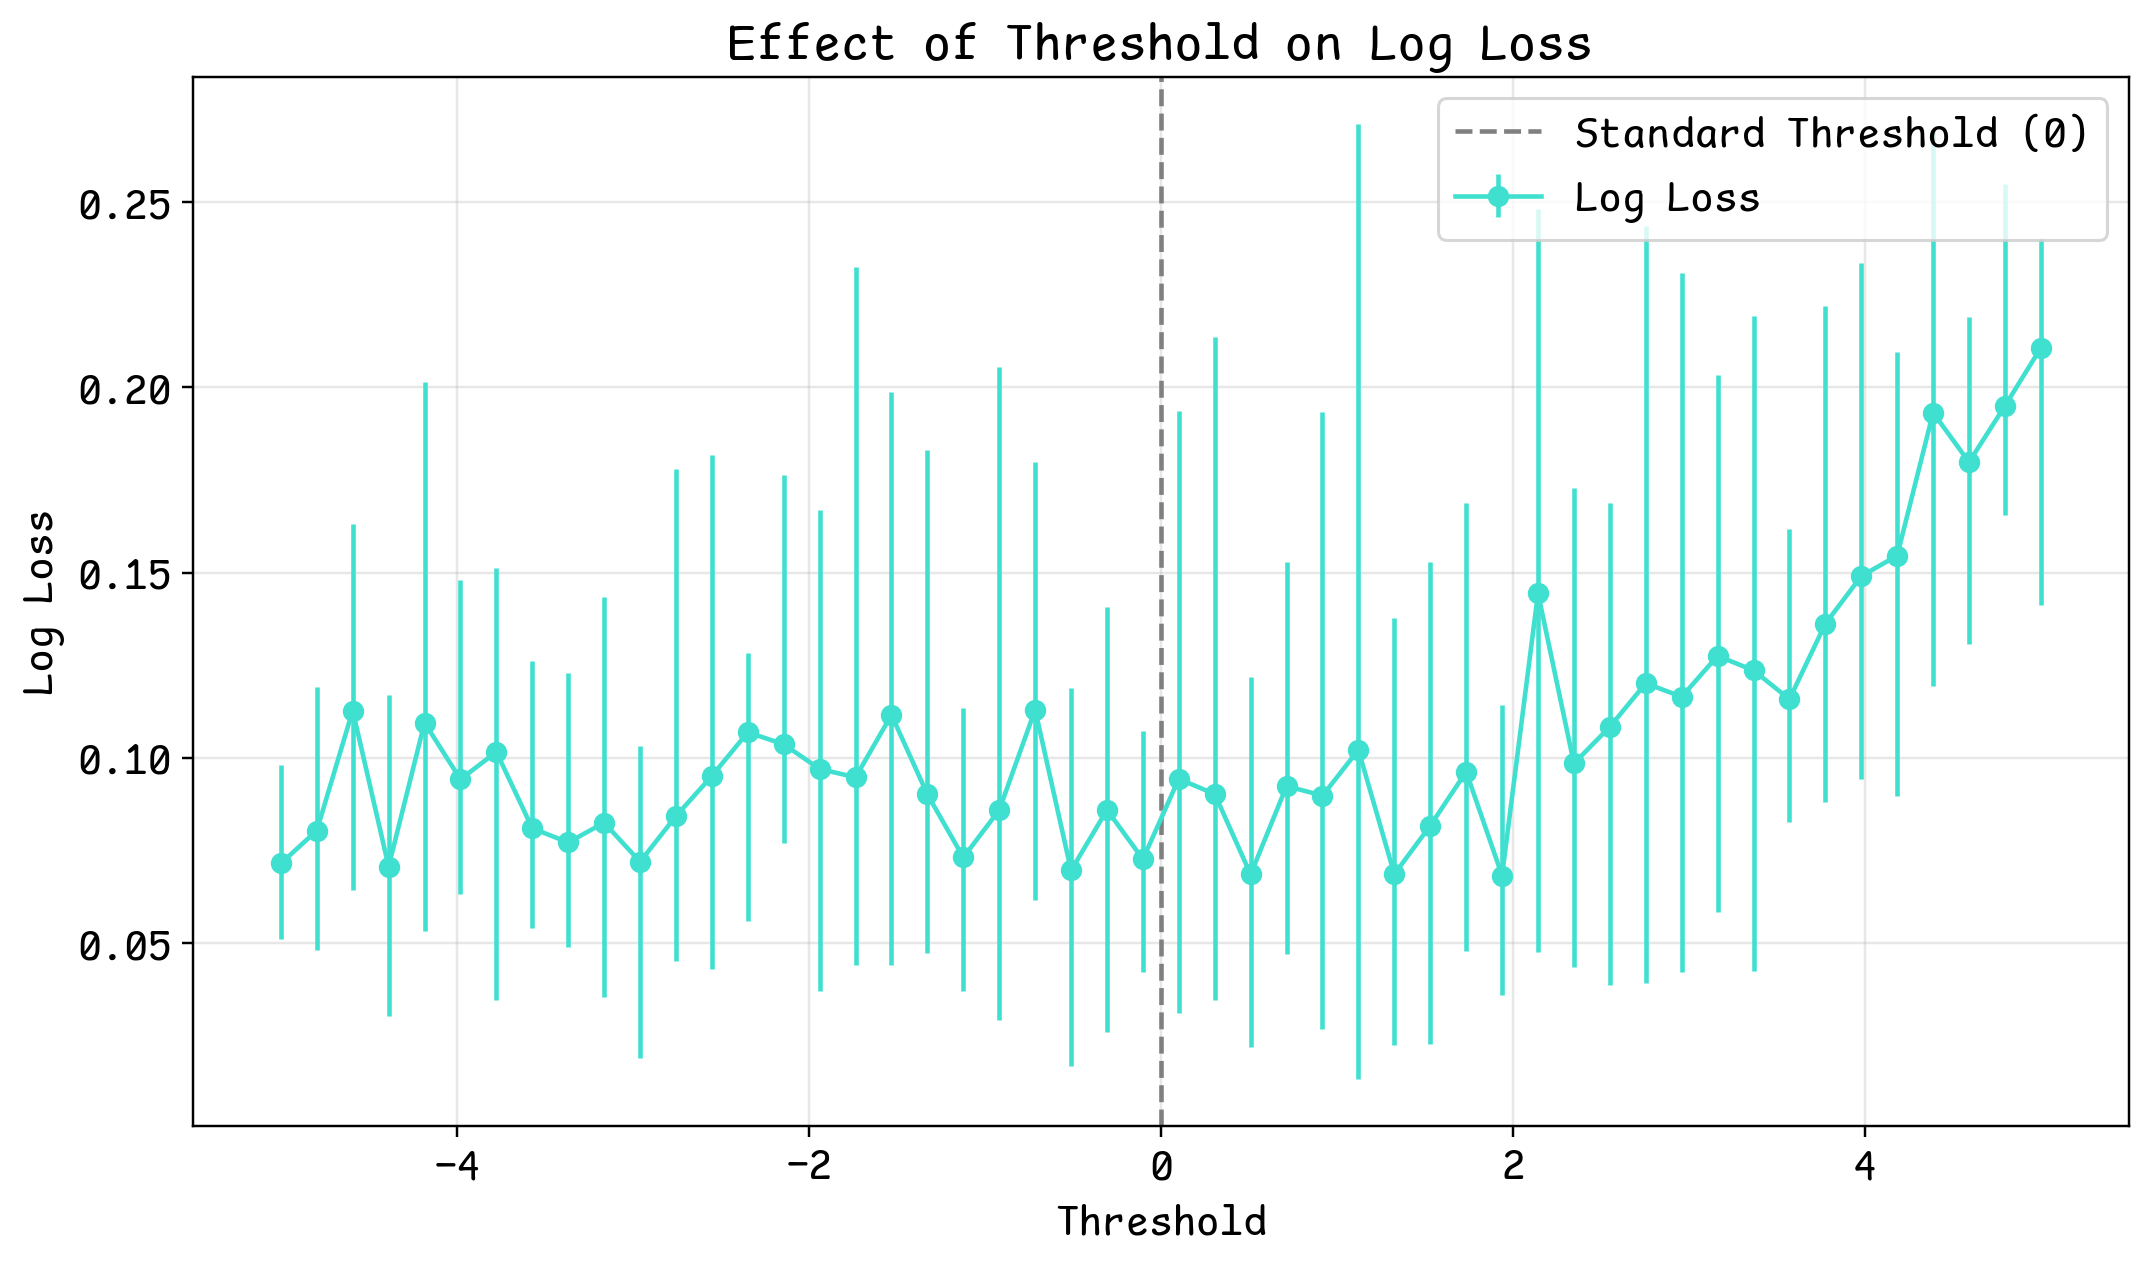

In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

# Generate synthetic imbalanced data with imbalance rate 0.05
NUM_SAMPLES = 1_000
ratio = 0.05
X, y = generate_imbalanced_data(num_samples=NUM_SAMPLES, imbalance_ratio=ratio, num_features=10)

# Simple Neural Network with a customizable ReLU threshold
class SimpleNN(nn.Module):
    def __init__(self, input_dim, threshold):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 50)
        self.relu = nn.ReLU() if threshold == 0 else nn.Threshold(threshold, 0)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Simulate thresholds
def simulate_thresholds(thresholds, num_bootstrap=10, imbalance_ratio=0.05):
    X, y = generate_imbalanced_data(imbalance_ratio=imbalance_ratio)
    dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(1))
    results = []

    for threshold in thresholds:
        bootstrap_log_losses = []
        for _ in range(num_bootstrap):
            # Split data randomly (80/20 split)
            indices = np.random.permutation(len(dataset))
            train_size = int(0.8 * len(dataset))
            train_indices, test_indices = indices[:train_size], indices[train_size:]
            
            # Fix: Index into dataset.tensors to create subsets
            train_dataset = DataLoader(
                TensorDataset(*[tensor[train_indices] for tensor in dataset.tensors]), batch_size=32
            )
            test_dataset = DataLoader(
                TensorDataset(*[tensor[test_indices] for tensor in dataset.tensors]), batch_size=32
            )

            # Train model
            model = SimpleNN(input_dim=10, threshold=threshold)
            criterion = nn.BCEWithLogitsLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
            for _ in range(10):  # Train for 10 epochs
                model.train()
                for inputs, targets in train_dataset:
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            # Evaluate model
            model.eval()
            all_outputs, all_targets = [], []
            with torch.no_grad():
                for inputs, targets in test_dataset:
                    outputs = model(inputs)
                    all_outputs.append(torch.sigmoid(outputs).cpu().numpy())
                    all_targets.append(targets.cpu().numpy())
            all_outputs = np.vstack(all_outputs)
            all_targets = np.vstack(all_targets)

            # Calculate log loss
            bootstrap_log_losses.append(log_loss(all_targets, all_outputs))

        # Store results for this threshold
        results.append({
            "Threshold": threshold,
            "Log Loss Mean": np.mean(bootstrap_log_losses),
            "Log Loss CI Lower": np.percentile(bootstrap_log_losses, 2.5),
            "Log Loss CI Upper": np.percentile(bootstrap_log_losses, 97.5)
        })

    return pd.DataFrame(results)

# Visualize the results
def plot_threshold_effect(results_df, standard_threshold=0):
    _, ax = plt.subplots(figsize=(10, 6), dpi=110)

    # Plot the log loss with confidence intervals
    ax.errorbar(
        results_df["Threshold"],
        results_df["Log Loss Mean"],
        yerr=[
            results_df["Log Loss Mean"] - results_df["Log Loss CI Lower"],
            results_df["Log Loss CI Upper"] - results_df["Log Loss Mean"]
        ],
        fmt='o-',
        label="Log Loss",
        color="turquoise",
        capsize=0
    )

    # Highlight the standard threshold
    ax.axvline(x=standard_threshold, color="gray", linestyle="--", label="Standard Threshold (0)")

    # Add labels and legend
    ax.set_title("Effect of Threshold on Log Loss")
    ax.set_xlabel("Threshold")
    ax.set_ylabel("Log Loss")
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Simulate and plot
thresholds = np.linspace(-5, 5, 50)
results_df = simulate_thresholds(thresholds)
plot_threshold_effect(results_df)

# Variant 2

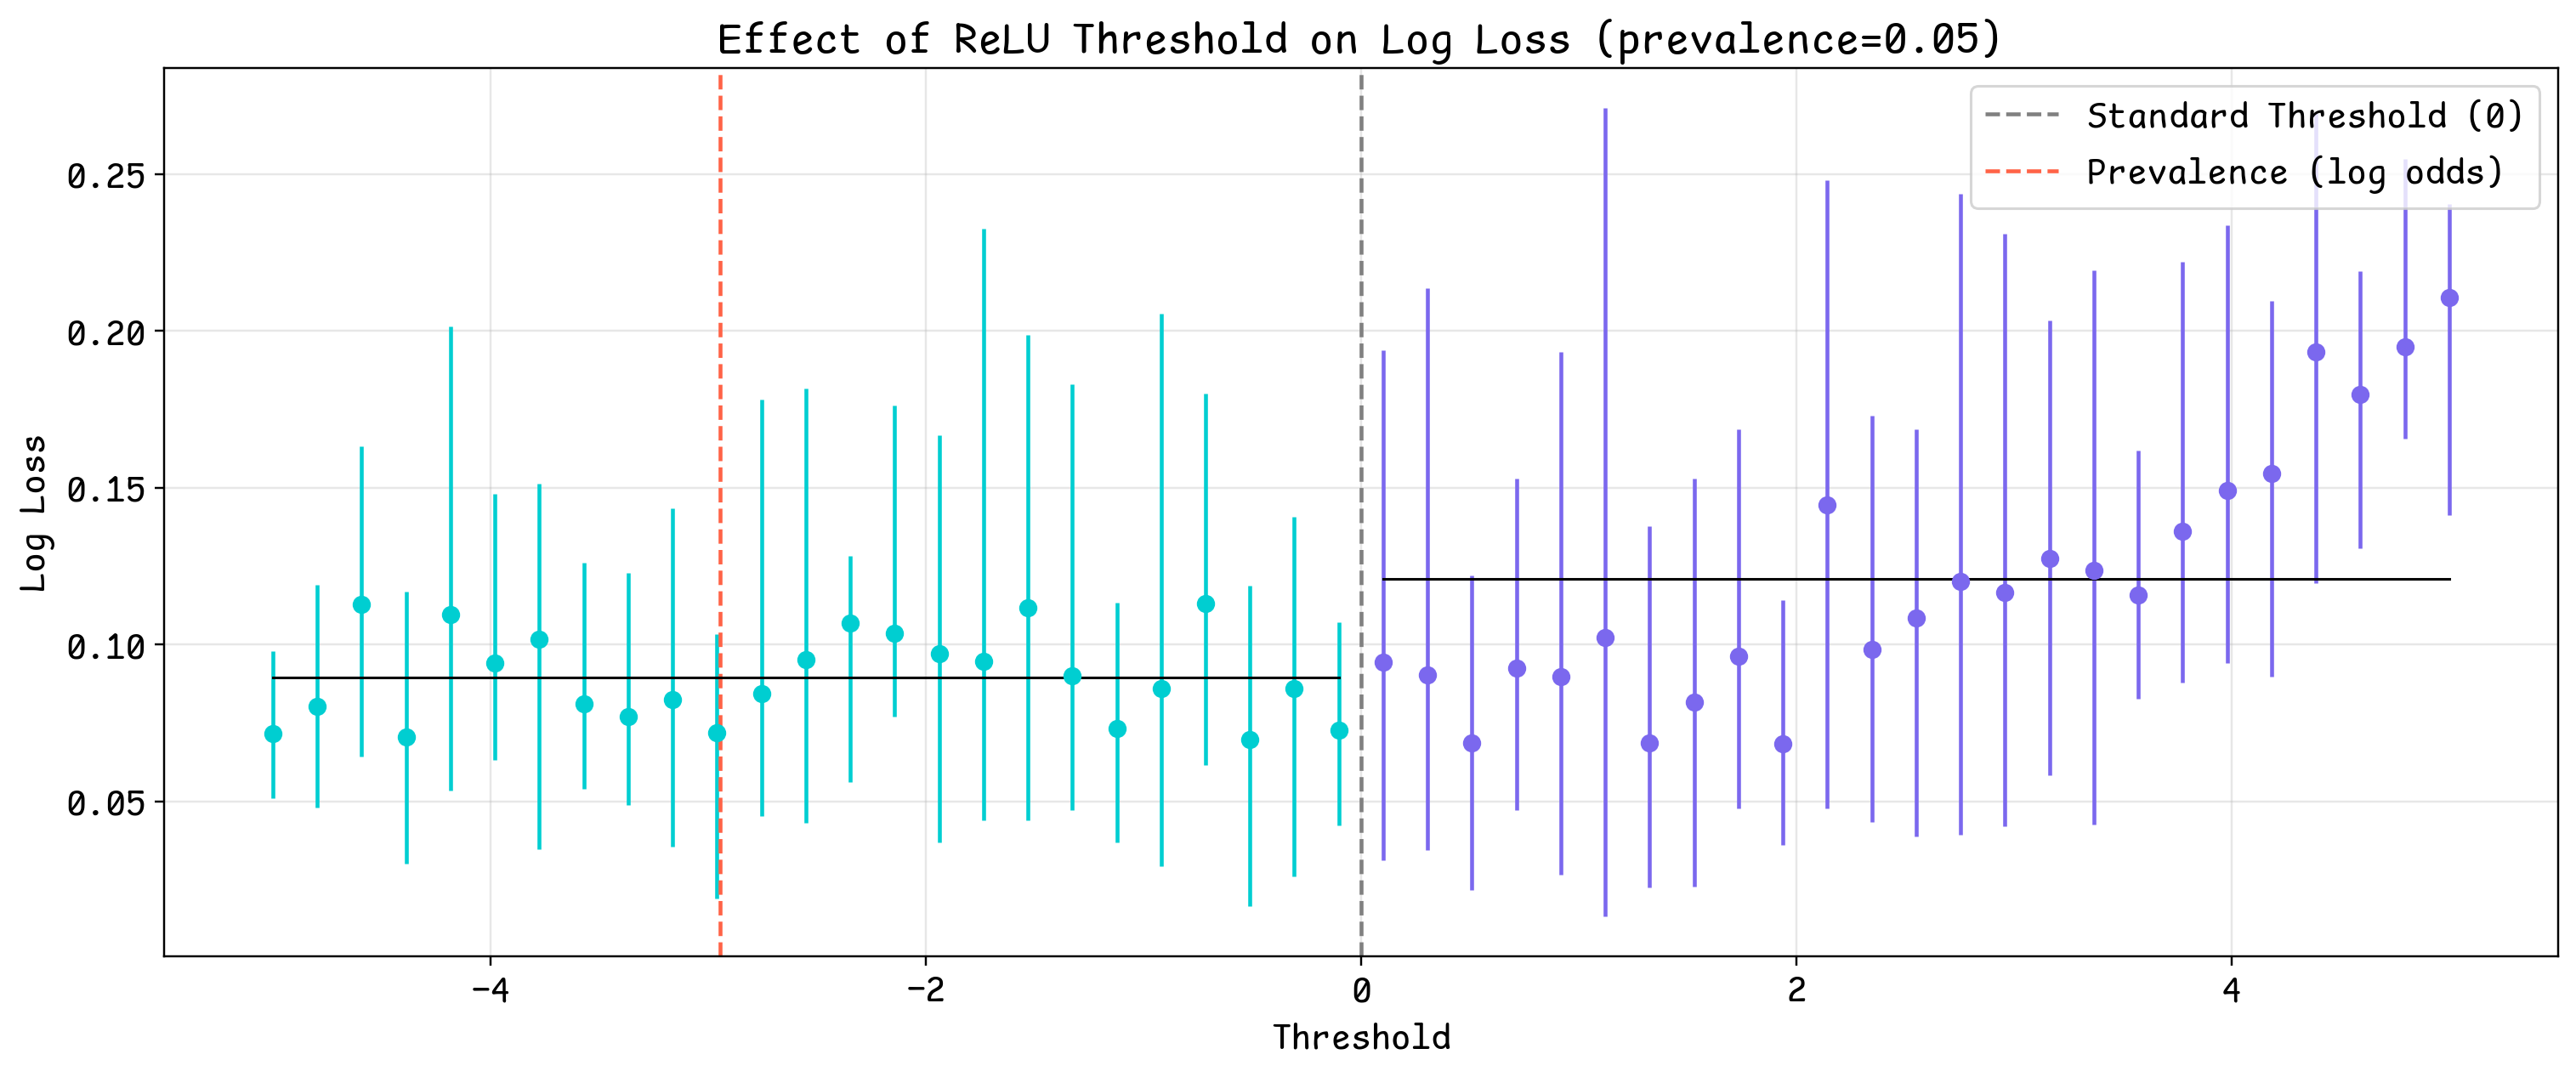

In [9]:
# Plot effects
color = '#00CED1' if model_type == "ReLU threshold=0" else "#7B68EE"
color_fill = '#AFEEEE' if model_type == "ReLU threshold=0" else "#CAC2F8"

# Visualize the results
def plot_threshold_effect(results_df, standard_threshold=0):
    fig, ax = plt.subplots(figsize=(14, 6), dpi=110)

    # Add 'group' column to the DataFrame
    results_df['group'] = np.where(results_df['Threshold'] < standard_threshold, 'Negative', 'Positive')

    # Plot Log Loss with error bars
    for group, color in zip(['Negative', 'Positive'], ['#00CED1', '#7B68EE']):
        group_data = results_df[results_df['group'] == group]
        ax.errorbar(
            group_data["Threshold"],
            group_data["Log Loss Mean"],
            yerr=[
                group_data["Log Loss Mean"] - group_data["Log Loss CI Lower"],
                group_data["Log Loss CI Upper"] - group_data["Log Loss Mean"]
            ],
            fmt='o',
            color=color,
            capsize=0
        )

    # Highlight the standard threshold
    ax.axvline(x=standard_threshold, color="gray", linestyle="--", label="Standard Threshold (0)")
    ax.axvline(x=logit(ratio), color="#FF6347", linestyle="--", label="Prevalence (log odds)")

    # Draw average lines for each group with restricted x-range
    group_means = results_df.groupby("group")["Log Loss Mean"].mean()
    for group, color in zip(['Negative', 'Positive'], ['red', 'blue']):
        group_data = results_df[results_df['group'] == group]
        mean_value = group_means[group]
        ax.plot(
            [group_data["Threshold"].min(), group_data["Threshold"].max()],
            [mean_value, mean_value],
            color='black',
            linewidth=1
        )

    # Add labels, legend, and grid
    ax.set_title("Effect of ReLU Threshold on Log Loss (prevalence=0.05)")
    ax.set_xlabel("Threshold")
    ax.set_ylabel("Log Loss")
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

results_df['group'] = np.where(results_df['Threshold'] < 0, 'Negative', 'Positive')
results_df.groupby('group').agg({'Log Loss Mean': 'mean', 'Log Loss CI Lower': 'mean', 'Log Loss CI Upper': 'mean'})

plot_threshold_effect(results_df)